In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_1d_distribution, kl_estimate_with_mc
from tqdm.notebook import trange, tqdm
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

The KL between q and p is 5.201 nats.


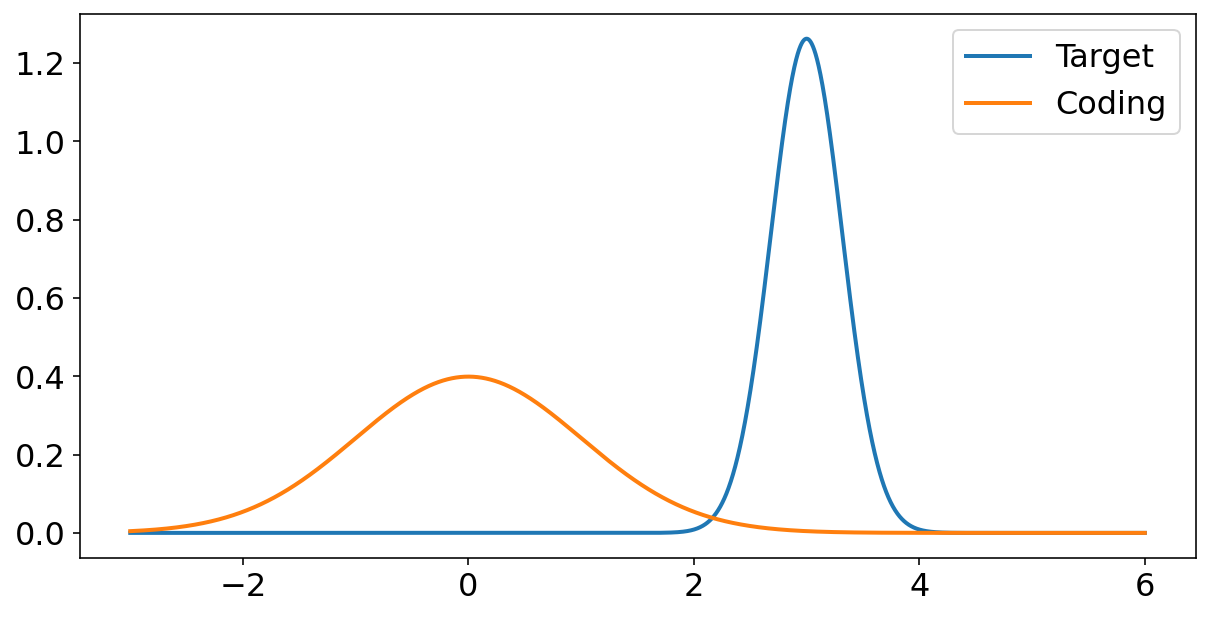

In [79]:
torch.manual_seed(100)

q_loc = 3.
q_var = 0.1

p_loc = 0.
p_var = 1.

# q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
# comp_q = dist.normal.Normal(loc=torch.tensor([10., 100.]), scale = math.pow(q_var, 0.5))
# mix_q = dist.categorical.Categorical(probs=torch.tensor([0.25, 0.75]))
# q = dist.MixtureSameFamily(mix_q, comp_q)
q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
p = dist.normal.Normal(loc=p_loc, scale = math.pow(p_var, 0.5))


try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=100000)
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-3, q_loc + 3, 5000)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')


ax.legend()

plt.show()

In [80]:
from scipy.stats import gamma, chi2, norm
import scipy

# Implementing the scheme

In [81]:
epsilon = 0.
num_aux = 1
num_samples_per_aux = math.ceil(math.exp(total_kl * (1+epsilon)))

In [90]:
greedy_samples = []
is_samples = []
biggest_samples = []
standard_greedy = []
prior = []
q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
p = dist.normal.Normal(loc=p_loc, scale = (p_var * 2) ** 0.5)
total_kl = dist.kl_divergence(q, p)
kl = [total_kl]
for j, seed in enumerate(tqdm(torch.arange(start=1000, end=1050))):
    torch.manual_seed(seed)
    aux_traj_greedy = torch.zeros([0])
    aux_traj_log_q_greedy = torch.zeros(1)
    aux_traj_log_p_greedy = torch.zeros(1)
    aux_traj_is = torch.zeros([0])
    aux_traj_log_q_is = torch.zeros(1)
    aux_traj_log_p_is = torch.zeros(1)
    biggest_sample = torch.zeros(1)
    
    if j > 1:
        prior.append([torch.clone(p.loc), torch.clone(p.scale)])
        old_var = p.scale ** 2
        # update the prior
        p.loc = (p_var * old_var)/(p_var + old_var)*(greedy_samples[-1]*p_var**-1 + p.loc*old_var**-1)
        p.scale = ((p_var**-1 + old_var**-1)**-1 + p_var) ** 0.5

        # compute new kl
        total_kl = dist.kl_divergence(q, p)
        kl.append(total_kl)
        num_samples_per_aux = math.ceil(math.exp(total_kl * (1+epsilon)))
    
    # sample trial aks
    trial_samples = p.sample((num_samples_per_aux,))
    biggest_sample += torch.max(trial_samples)


    # compute log q
    log_q = q.log_prob(trial_samples)

    # compute log p
    log_p= p.log_prob(trial_samples)

    # choose best sample
    log_iw = log_q - log_p
    greedy_idx = torch.argmax(log_iw)
    z_greedy = trial_samples[greedy_idx]

    # IMPORTANCE SAMPLING

    # make categorical dist
    cat = dist.Categorical(probs=torch.exp(log_iw))
    is_idx = cat.sample()

    is_chosen_sample = trial_samples[is_idx]
    z_is = torch.cat([aux_traj_is, is_chosen_sample[None]])


    greedy_samples.append(z_greedy)
    is_samples.append(z_is)
    biggest_samples.append(biggest_sample)
    
    # sample from original prior
    p_0 = dist.Normal(loc=0., scale=(p_var * 2)**0.5)
    trial_samples_0 = p_0.sample((num_samples_per_aux,))
    
    # compute log q
    log_q_0 = q.log_prob(trial_samples_0)

    # compute log p
    log_p_0 = p.log_prob(trial_samples_0)

    # choose best sample
    log_iw_0 = log_q_0 - log_p_0
    greedy_idx_0 = torch.argmax(log_iw_0)
    z_greedy_0 = trial_samples_0[greedy_idx_0]
    
    standard_greedy.append(z_greedy_0)
        

  0%|          | 0/50 [00:00<?, ?it/s]

## num_samples_per_aux

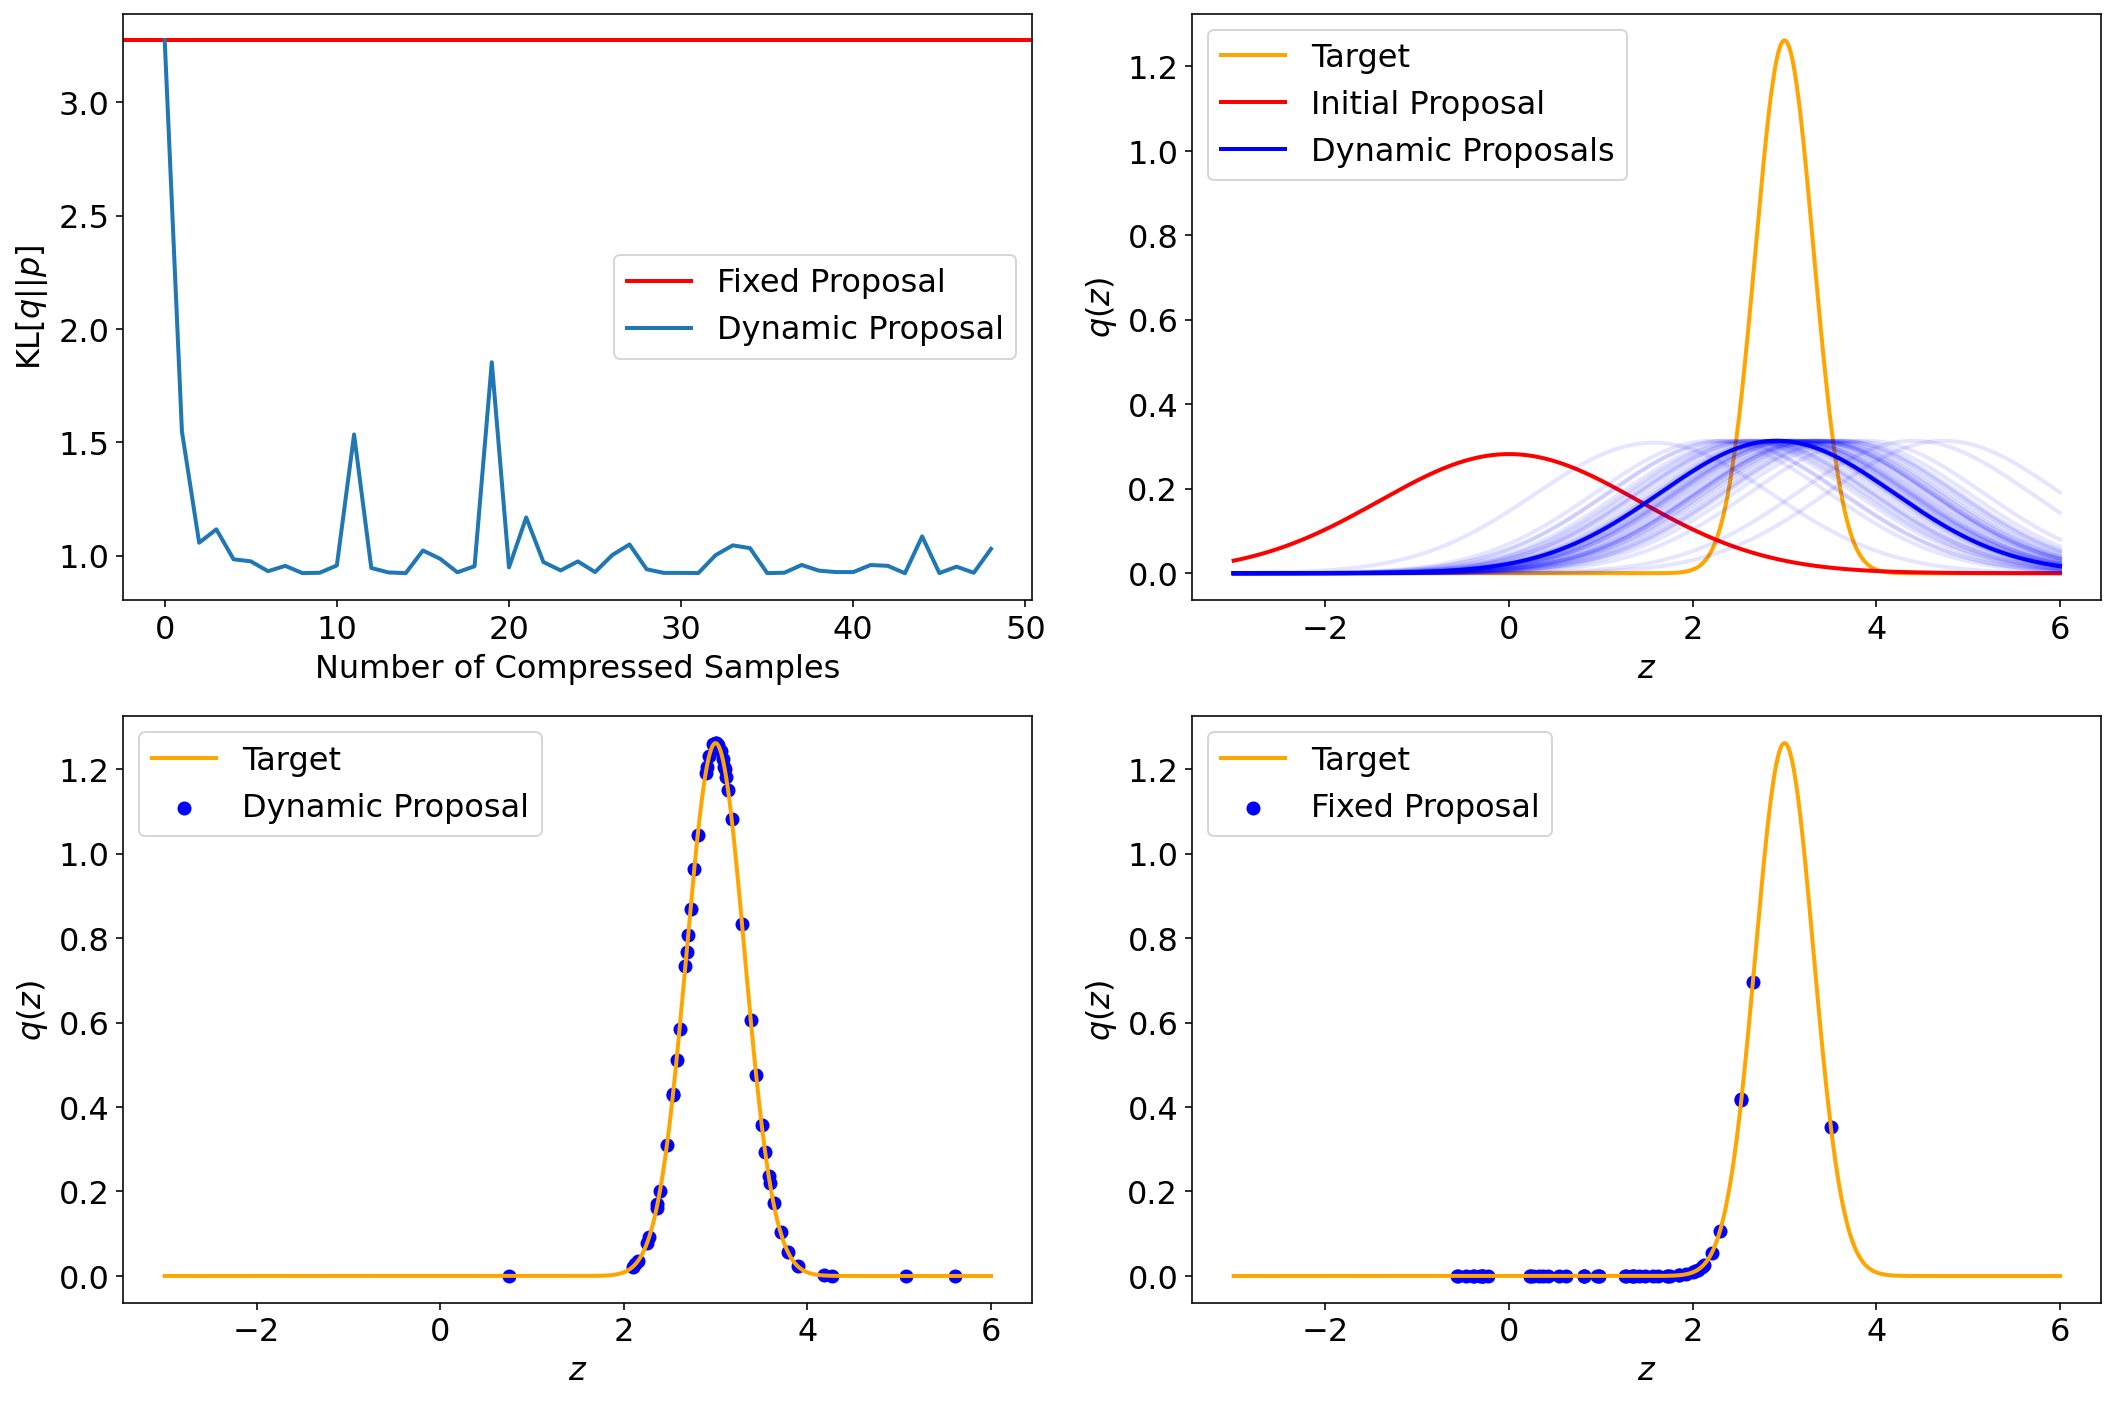

In [91]:
f, ax = plt.subplots(2,2, figsize=(15,10))
ax[0, 1].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')

for i, (loc, scale) in enumerate(prior):

    p_k = dist.Normal(loc=loc, scale=scale)
    if i==0:
        ax[0, 1].plot(xs, torch.exp(p_k.log_prob(xs)), label='Initial Proposal', color='red')
    elif i==len(prior)-1:
        ax[0, 1].plot(xs, torch.exp(p_k.log_prob(xs)), color='blue',alpha=1, label='Dynamic Proposals')
    else:
        ax[0, 1].plot(xs, torch.exp(p_k.log_prob(xs)), color='blue',alpha=.1)
        

ax[0, 1].set_xlabel(r'$z$')
ax[0, 1].set_ylabel(r'$q(z)$')

ax[0, 0].axhline(kl[0], color='red', label='Fixed Proposal')
ax[0, 0].plot(kl, label='Dynamic Proposal')

ax[0, 0].set_xlabel('Number of Compressed Samples')
ax[0, 0].set_ylabel(r'$\mathrm{KL}[q\|\|p]$')


ax[1, 0].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
ax[1, 0].scatter(greedy_samples, torch.exp(q.log_prob(torch.tensor(greedy_samples))), 
                 color='blue',
                 label='Dynamic Proposal')
ax[1, 0].set_xlabel(r'$z$')
ax[1, 0].set_ylabel(r'$q(z)$')
ax[1, 1].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
ax[1, 1].scatter(standard_greedy, torch.exp(q.log_prob(torch.tensor(standard_greedy))),
                 color='blue',
                 label='Fixed Proposal')
ax[1, 1].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[0, 0].legend()
ax[1, 1].set_xlabel(r'$z$')
ax[1, 1].set_ylabel(r'$q(z)$')
f.tight_layout()
f.savefig("Figures/Thesis/DynamicProposal.pdf", bbox_inches='tight')

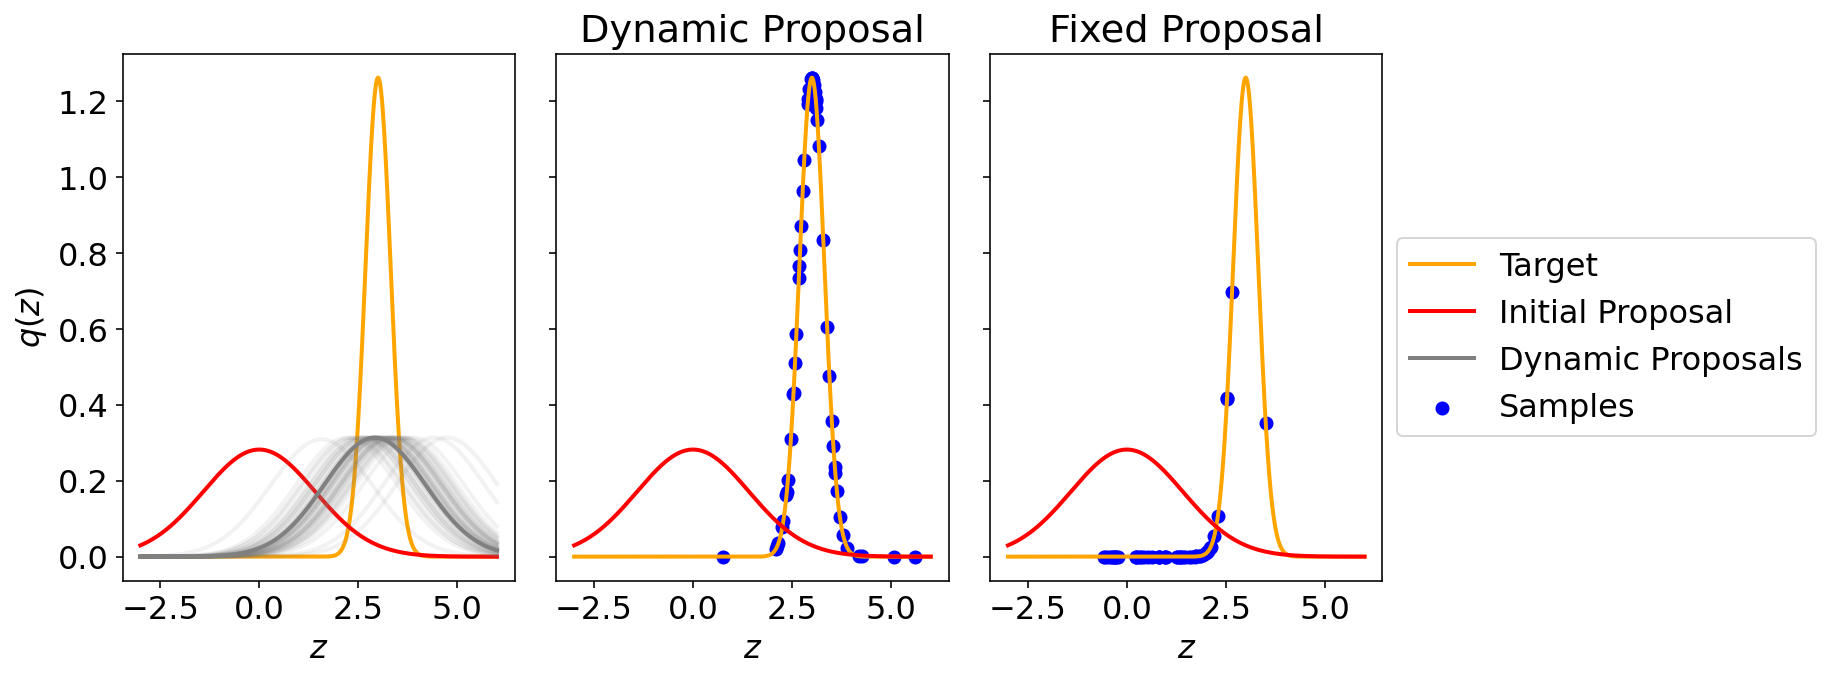

In [95]:
f, ax = plt.subplots(1,3, figsize=(10,5), sharex=True, sharey=True)
ax[0].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
p = dist.Normal(loc=prior[0][0], scale=prior[0][1])
for i, (loc, scale) in enumerate(prior):

    p_k = dist.Normal(loc=loc, scale=scale)
    if i==0:
        ax[0].plot(xs, torch.exp(p_k.log_prob(xs)), label='Initial Proposal', color='red')
    elif i==len(prior)-1:
        ax[0].plot(xs, torch.exp(p_k.log_prob(xs)), color='gray',alpha=1, label='Dynamic Proposals')
    else:
        ax[0].plot(xs, torch.exp(p_k.log_prob(xs)), color='gray',alpha=.1)
        

ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$q(z)$')


ax[1].plot(xs, torch.exp(q.log_prob(xs)), color='orange')
ax[1].plot(xs, torch.exp(p.log_prob(xs)), color='red')
ax[1].scatter(greedy_samples, torch.exp(q.log_prob(torch.tensor(greedy_samples))), 
                 color='blue')
ax[1].set_xlabel(r'$z$')
ax[2].plot(xs, torch.exp(q.log_prob(xs)), color='orange')
ax[2].plot(xs, torch.exp(p.log_prob(xs)), color='red')
ax[2].scatter(standard_greedy, torch.exp(q.log_prob(torch.tensor(standard_greedy))),
                 color='blue',
                 label='Samples')

ax[1].set_title('Dynamic Proposal')
ax[2].set_title('Fixed Proposal')
ax[2].set_xlabel(r'$z$')
f.legend(bbox_to_anchor=(.975, .5), loc='center left')
f.tight_layout()
f.savefig("Figures/Thesis/DynamicProposal_Samples.pdf", bbox_inches='tight')

In [96]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

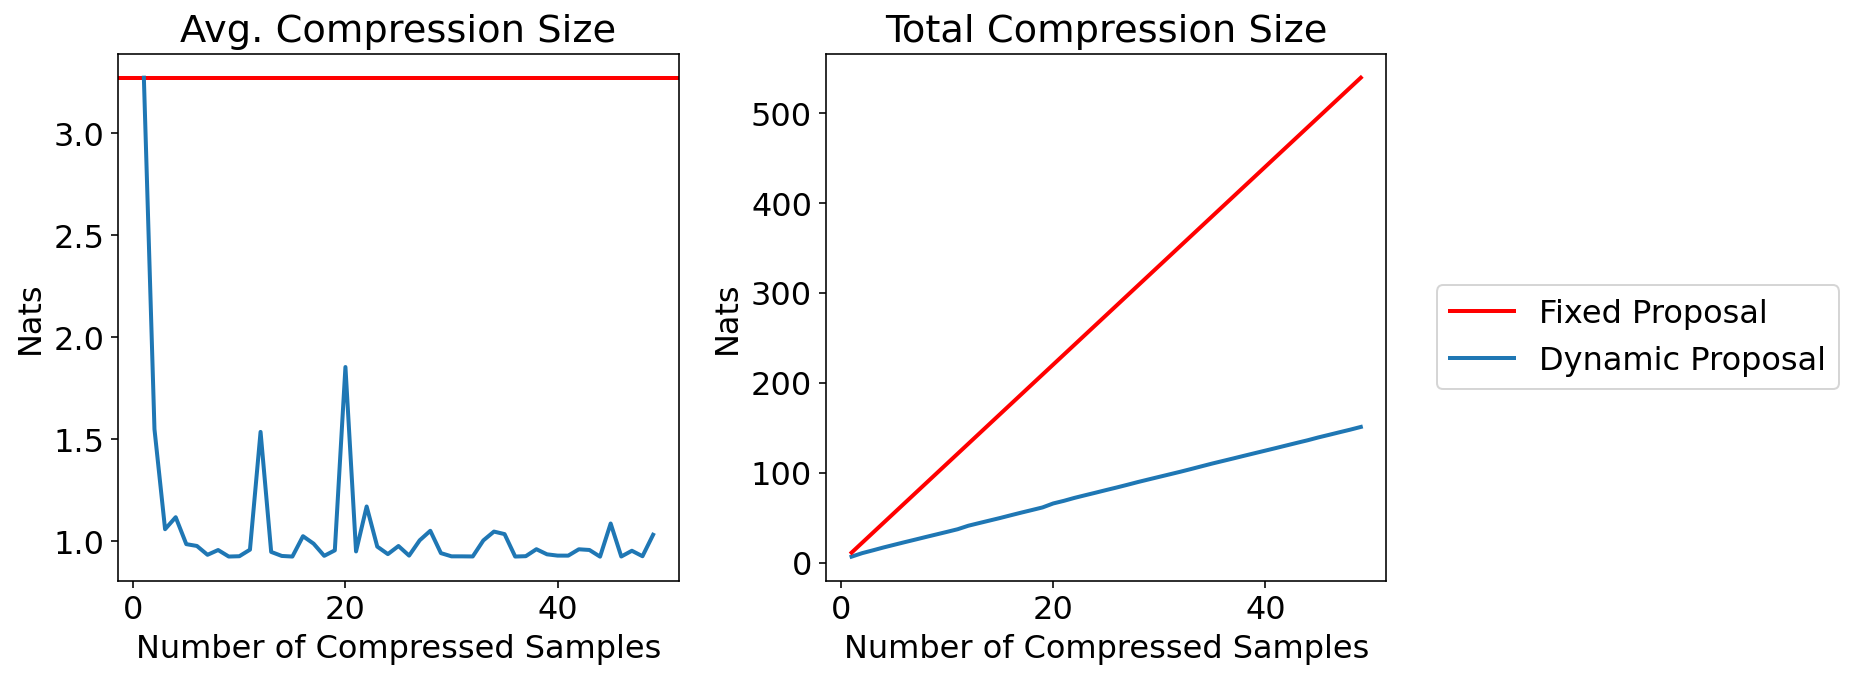

In [97]:
f, ax = plt.subplots(1,2, sharex=True, figsize=(10, 5))
kl_tensor = compute_expected_coding_efficiency(torch.tensor(kl))
fixed_tensor = compute_expected_coding_efficiency(torch.ones_like(kl_tensor) * kl_tensor[0])
ax[1].plot(np.arange(1, 50), kl_tensor.cumsum(0))
ax[1].plot(np.arange(1, 50), fixed_tensor.cumsum(0), color='red')
ax[0].set_ylabel('Avg. Compression Size')
ax[1].set_ylabel('Total Compression Size')
ax[0].axhline(kl[0], color='red', label='Fixed Proposal')
ax[0].plot(np.arange(1, 50), kl, label='Dynamic Proposal')

ax[0].set_ylabel('Nats')
ax[1].set_ylabel('Nats')
ax[0].set_xlabel('Number of Compressed Samples')
ax[1].set_xlabel('Number of Compressed Samples')
ax[0].set_title('Avg. Compression Size')
ax[1].set_title('Total Compression Size')
f.legend(['Fixed Proposal', 'Dynamic Proposal'], bbox_to_anchor=(1., .5), loc='center left')
f.tight_layout()
f.savefig("Figures/Thesis/DynamicProposal_CompressionSize.pdf", bbox_inches='tight')

# Enforce Monotonicity

In [223]:
greedy_samples = []
is_samples = []
biggest_samples = []
standard_greedy = []

q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
p = dist.normal.Normal(loc=p_loc, scale = (p_var * 2) ** 0.5)
total_kl = dist.kl_divergence(q, p)
kl = [total_kl]
for j, seed in enumerate(tqdm(torch.randint(low=0, high=int(1e10), size=(100,)))):
    torch.manual_seed(seed)
    aux_traj_greedy = torch.zeros([0])
    aux_traj_log_q_greedy = torch.zeros(1)
    aux_traj_log_p_greedy = torch.zeros(1)
    aux_traj_is = torch.zeros([0])
    aux_traj_log_q_is = torch.zeros(1)
    aux_traj_log_p_is = torch.zeros(1)
    biggest_sample = torch.zeros(1)
    
    if j > 1:
        prior.append([torch.clone(p.loc), torch.clone(p.scale)])
        # update the prior
        p.loc = 0.5*p.loc + 0.5*greedy_samples[-1]
        p.scale = ((p.scale ** -2 + 1) ** -0.5 + p_var) ** 0.5

        # compute new kl
        total_kl = dist.kl_divergence(q, p)
        kl.append(total_kl)
        num_samples_per_aux = math.ceil(math.exp(total_kl * (1+epsilon)))
    
    # sample trial aks
    trial_sample = p.loc
    trial_samples = p.sample((num_samples_per_aux,))
    trial_samples = torch.cat([trial_sample[None], trial_samples], dim=-1)
    biggest_sample += torch.max(trial_samples)


    # compute log q
    log_q = q.log_prob(trial_samples)

    # compute log p
    log_p= p.log_prob(trial_samples)

    # choose best sample
    log_iw = log_q - log_p
    greedy_idx = torch.argmax(log_iw)
    z_greedy = trial_samples[greedy_idx]

    # IMPORTANCE SAMPLING

    # make categorical dist
    cat = dist.Categorical(probs=torch.exp(log_iw))
    is_idx = cat.sample()

    is_chosen_sample = trial_samples[is_idx]
    z_is = torch.cat([aux_traj_is, is_chosen_sample[None]])


    greedy_samples.append(z_greedy)
    is_samples.append(z_is)
    biggest_samples.append(biggest_sample)
    
    # sample from original prior
    p_0 = dist.Normal(loc=0., scale=1.)
    trial_sample_0 = p_0.loc
    trial_samples_0 = p_0.sample((num_samples_per_aux,))
    trial_samples_0 = torch.cat([trial_sample_0[None], trial_samples_0], dim=-1)
    
    # compute log q
    log_q_0 = q.log_prob(trial_samples_0)

    # compute log p
    log_p_0 = p.log_prob(trial_samples_0)

    # choose best sample
    log_iw_0 = log_q_0 - log_p_0
    greedy_idx_0 = torch.argmax(log_iw_0)
    z_greedy_0 = trial_samples_0[greedy_idx_0]
    
    standard_greedy.append(z_greedy_0)
        

  0%|          | 0/100 [00:00<?, ?it/s]

## num_samples_per_aux

Text(0, 0.5, '$q(z)$')

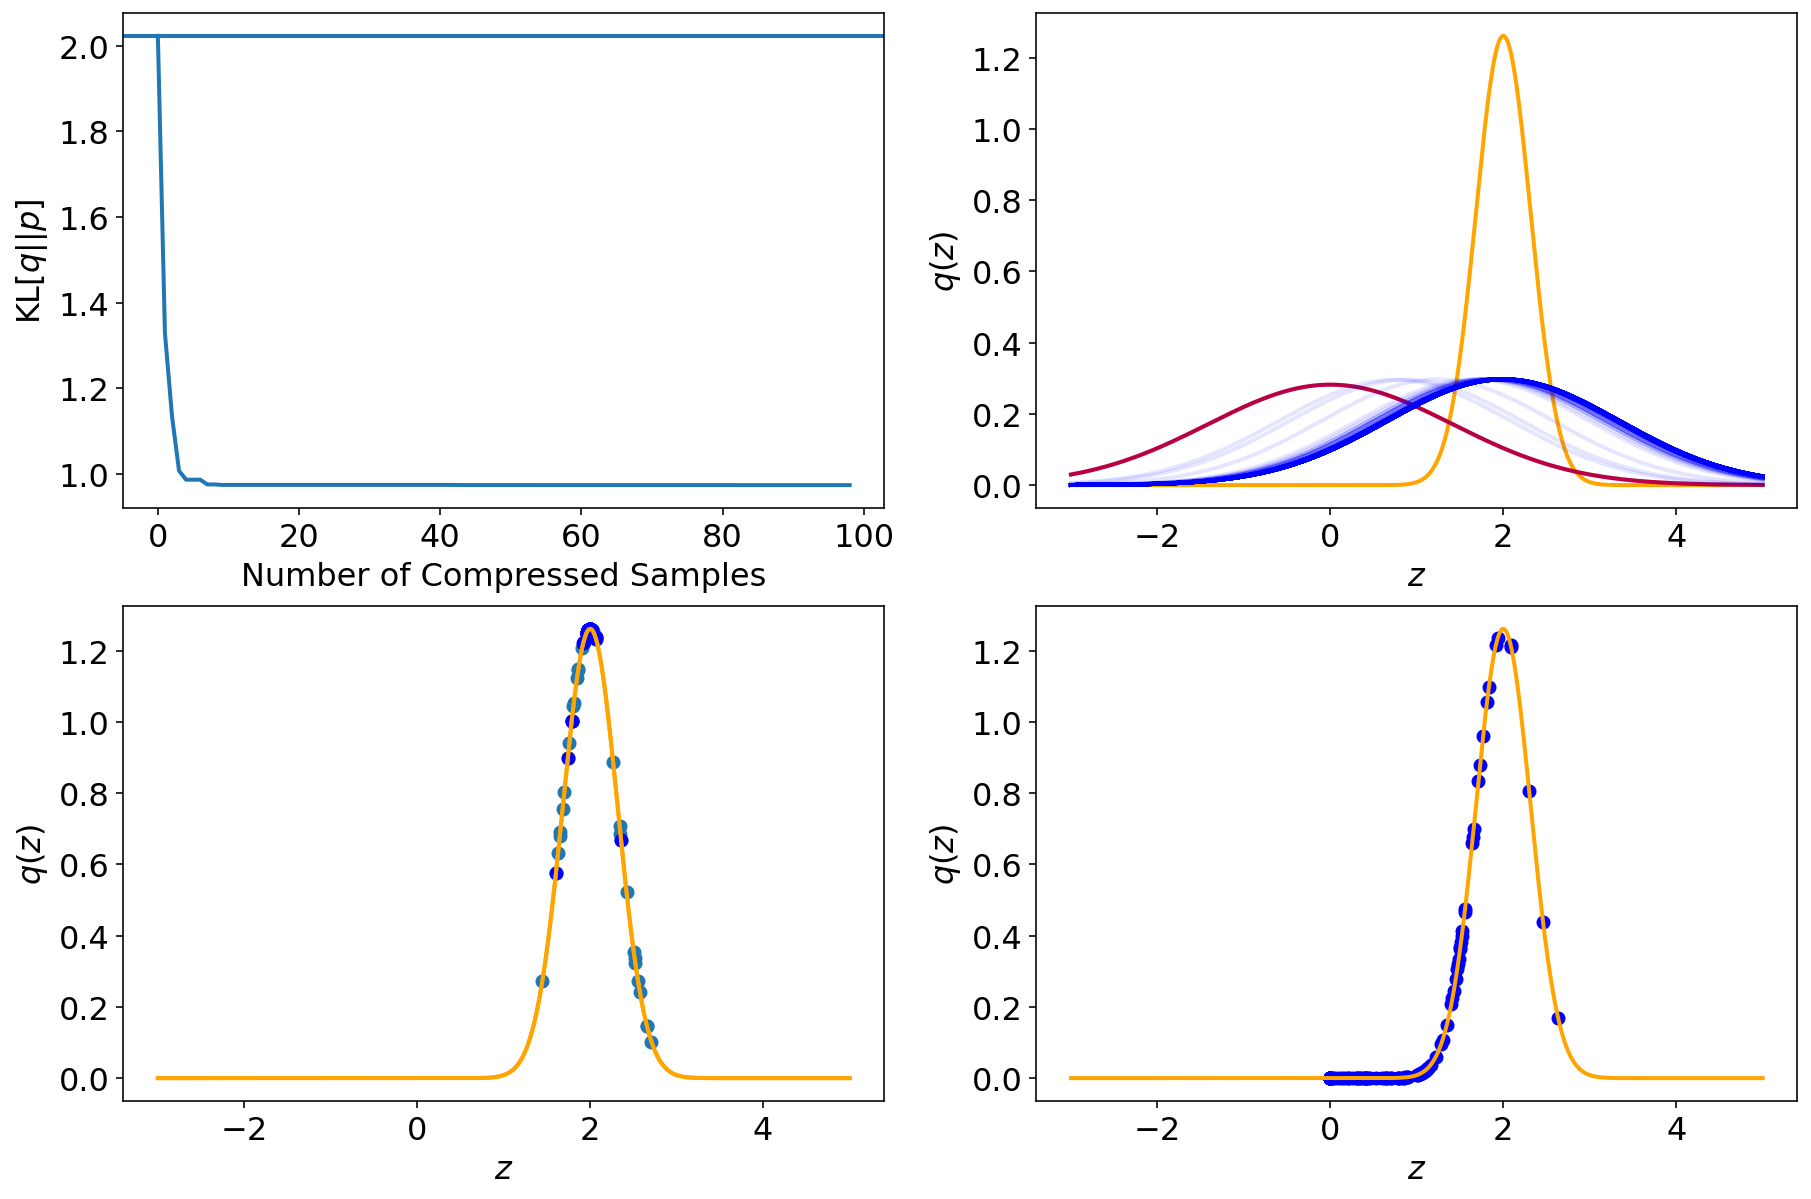

In [224]:
f, ax = plt.subplots(2,2, figsize=(15,10))
ax[0, 1].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
ax[0, 1].plot(xs, torch.exp(dist.Normal(loc=0, scale=(2*p_var)**0.5).log_prob(xs)), label='Initial Proposal', color='red')
for i, (loc, scale) in enumerate(prior):
    p_k = dist.Normal(loc=loc, scale=scale)
    ax[0, 1].plot(xs, torch.exp(p_k.log_prob(xs)), label=f'$p_{i}$', color='blue',alpha=.1)

ax[0, 1].set_xlabel(r'$z$')
ax[0, 1].set_ylabel(r'$q(z)$')


ax[0, 0].plot(kl)
ax[0, 0].axhline(kl[0])
ax[0, 0].set_xlabel('Number of Compressed Samples')
ax[0, 0].set_ylabel(r'$\mathrm{KL}[q\|\|p]$')

ax[1, 0].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
ax[1, 0].scatter(is_samples, torch.exp(q.log_prob(torch.tensor(is_samples))))

ax[1, 0].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
ax[1, 0].scatter(greedy_samples, torch.exp(q.log_prob(torch.tensor(greedy_samples))), 
                 color='blue',
                 label='iREC with dynamic Proposal')
ax[1, 0].set_xlabel(r'$z$')
ax[1, 0].set_ylabel(r'$q(z)$')
ax[1, 1].plot(xs, torch.exp(q.log_prob(xs)), label='Target', color='orange')
ax[1, 1].scatter(standard_greedy, torch.exp(q.log_prob(torch.tensor(standard_greedy))),
                 color='blue',
                 label='Standard iREC')
ax[1, 1].set_xlabel(r'$z$')
ax[1, 1].set_ylabel(r'$q(z)$')